# Introduction

This notebook seeks to reproduce the results from *Fourier Features Let Networks Learn
High Frequency Functions in Low Dimensional Domains* ([link](https://bmild.github.io/fourfeat/))

Specifically, this notebook experiments with a 2D image regression problem. Formally, we wish to reconstruct images by approximating the following function:

$(x,y) \rightarrow (rgb)$


Due to the [spectral bias of neural networks](https://arxiv.org/abs/1806.08734), the MLP is biased towards learning lower frequency functions first. This bias can be overcome by mapping the input features using random fourier features:

$\gamma(\mathbf{v}) = [ \cos(2\pi \mathbf{Bv}), \sin(2\pi \mathbf{Bv}) ]^T,  B \sim N(0,\sigma^2)$


The fourier feature scale $\sigma^2$ becomes an adjustable parameter which effectively controls the bandwidth of the neural tangent kernel. In other words, a too low feature scale will oversmooth (and thus underfit), while a too high feature scale will "oversharpen" (and thus overfit).

In [17]:
import torch
import torch.nn.functional as F
from torch import optim, nn
from torch.utils.data import DataLoader
from skimage import data
import pytorch_lightning as pl
import matplotlib.pyplot as plt

# Prepare data

In [5]:
X = torch.tensor(data.cat())

train_data = [
    {
        'pos': torch.tensor([
            x / X.shape[0],
            y / X.shape[1]
        ]),
        'target': X[x,y]/255
    }
    for x in torch.arange(0,X.shape[0],2)
    for y in torch.arange(0,X.shape[1],2)
]

test_data = [
    {
        'pos': torch.tensor([
            x / X.shape[0],
            y / X.shape[1]
        ]),
        'target': X[x,y]/255
    }
    for x in torch.arange(0,X.shape[0])
    for y in torch.arange(0,X.shape[1])
]

# Fit MLPs

In [39]:
class GaussianEncoding(nn.Module):
    def __init__(self, dim=2, m=128, sigma=10):
        super().__init__()
        self.m = m
        self.sigma = sigma
        self.B = self.sigma*torch.randn((2,m))
        
    def forward(self, x):
        term = 2*torch.pi*(x@self.B)
        return torch.cat((torch.cos(term), torch.sin(term)), dim=-1)
    

class Net(pl.LightningModule):
    def __init__(self, pos_enc=False):
        super().__init__()
        if pos_enc:
            #enc = [rff.layers.GaussianEncoding(sigma=10, input_size=2, encoded_size=128)]
            enc = [GaussianEncoding()]
        else:
            enc = []
        self.seq = nn.Sequential(
            *enc,
            nn.LazyLinear(256),
            nn.ReLU(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.LazyLinear(64),
            nn.ReLU(),
            nn.LazyLinear(3),
            nn.Sigmoid()
        )
        
    def configure_optimizers(self):
        opt = optim.Adam(self.parameters())
        return opt
        
    def forward(self, x):
        return self.seq(x)
    
    def training_step(self, batch, batch_idx):
        pred = self(batch['pos'])
        loss = F.mse_loss(pred, batch['target'])
        return loss

batch_size = 1024
train_loader = DataLoader(train_data, batch_size=batch_size)
trainer_args = dict(accelerator='cpu', enable_progress_bar=True, logger=False, max_epochs=25, checkpoint_callback=False)

# without encoding
model = Net()
trainer = pl.Trainer(**trainer_args)
trainer.fit(model, train_dataloaders=train_loader)

# with encoding
model_with_enc = Net(pos_enc=True)
trainer = pl.Trainer(**trainer_args)
trainer.fit(model_with_enc, train_dataloaders=train_loader)

TypeError: __init__() got an unexpected keyword argument 'checkpoint_callback'

# Results

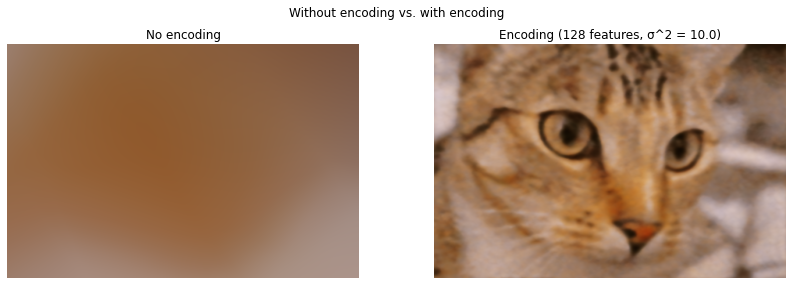

In [38]:
val_loader = DataLoader(test_data, batch_size=len(test_data))
with torch.no_grad():
    out = model(next(iter(val_loader))['pos'])
    out_pos_enc = model_with_enc(next(iter(val_loader))['pos'])
out = out.reshape((*X.shape[:2],3))
out_pos_enc = out_pos_enc.reshape((*X.shape[:2],3))

plt.figure(figsize=(12,4))
plt.suptitle('Without encoding vs. with encoding')
plt.subplot(1,2,1)
plt.title('No encoding')
plt.imshow(out)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Encoding (%d features, σ^2 = %.1f)' % (model_with_enc.seq[0].m, model_with_enc.seq[0].sigma))
plt.imshow(out_pos_enc)
plt.axis('off')
plt.tight_layout()
plt.show()